# `Libraries`

In [16]:
%%capture
!pip install pandas
!pip install pyspark
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip3 install tqdm

# `Preparing the Data`

In [7]:
import pandas as pd

train_df = pd.read_csv('../data/car_dataset_train.csv')
train_df.head(10)

,Unnamed: 0,x1,y1,x2,y2,Class,image
0,0,39,116,569,375,14,00001.jpg
1,1,36,116,868,587,3,00002.jpg
2,2,85,109,601,381,91,00003.jpg
3,3,621,393,1484,1096,134,00004.jpg
4,4,14,36,133,99,106,00005.jpg
5,5,259,289,515,416,123,00006.jpg
6,6,88,80,541,397,89,00007.jpg
7,7,73,79,591,410,96,00008.jpg
8,8,20,126,1269,771,167,00009.jpg
9,9,21,110,623,367,58,00010.jpg


In [8]:
train_df.size

57008

In [9]:
train_df.shape

(8144, 7)

In [10]:
# unique classes in the dataset
train_df['Class'].unique().size

196

# `Resizing Images Using PyTorch`

In [12]:
# transformations
import os
from PIL import Image
from torchvision import transforms

# data directories
data_directory = "../data"
train_images = data_directory + "/cars_train"

# needed input dimensions for the CNN
input_dim = (224,224)
input_dir_cnn = data_directory + "/input_images_cnn"

os.makedirs(input_dir_cnn, exist_ok = True)

transformation_for_cnn_input = transforms.Compose([transforms.Resize(input_dim)])

for image_name in os.listdir(train_images):
    I = Image.open(os.path.join(train_images, image_name))
    newI = transformation_for_cnn_input(I)
    newI.save(os.path.join(input_dir_cnn, image_name))
    newI.close()
    I.close()

# `Image Embeddings Using ResNet-18`

In [14]:
import torch
from torchvision import models

class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor() # Convert images into the PyTorch tensor format.
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   
    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        return cnnModel, layer
   
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)
        def copyData(m, i, o): embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()
        return embedding.numpy()[0, :, 0, 0]

In [18]:
# We now initialize the Img2VecResnet18 class and apply the getVec method to all of the images to obtain their image embeddings.
import os
import tqdm
from tqdm import tqdm  # Explicitly import tqdm from the module
from PIL import Image, ImageOps  # Import Image and ImageOps for handling image modes

img2vec = Img2VecResnet18()
allVectors = {}

# Lista de extensiones válidas para imágenes
valid_extensions = (".jpg", ".png")

for image in tqdm(os.listdir(input_dir_cnn)):
    image_path = os.path.join(input_dir_cnn, image)

    # Verificar si es un archivo y si tiene una extensión de imagen válida
    if os.path.isfile(image_path) and image.lower().endswith(valid_extensions):
        I = Image.open(image_path)
        
        # Convertir imágenes en escala de grises a RGB
        if I.mode != 'RGB':
            I = I.convert('RGB')

        vec = img2vec.getVec(I)
        allVectors[image] = vec
        I.close()


100%|██████████| 8145/8145 [04:00<00:00, 33.81it/s]


In [19]:
# Save the image embeddings to a CSV file

pd.DataFrame(allVectors).transpose().to_csv(data_directory + '/input_data_vectors.csv')

# Import image embeddings into pyspark dataframe

In [23]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('Cars') \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

spark


25/02/27 19:38:02 WARN Utils: Your hostname, charly resolves to a loopback address: 127.0.1.1; using 192.168.1.8 instead (on interface wlp0s20f3)


# Import Image Embeddings into PySpark

In [28]:
input_df = spark.read.option('inferSchema', True).csv(data_directory + '/input_data_vectors.csv')
input_df.columns[:10]

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9']

In [29]:
from pyspark.ml.feature import VectorAssembler

vector_columns = input_df.columns[1:]
assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")

output = assembler.transform(input_df)
output = output.select('_c0', 'features')
output.show(3, vertical=True)

-RECORD 0------------------------
 _c0      | NULL                 
 features | [0.0,1.0,2.0,3.0,... 
-RECORD 1------------------------
 _c0      | 07269.jpg            
 features | [0.22489041,2.102... 
-RECORD 2------------------------
 _c0      | 05336.jpg            
 features | [0.676869,3.26460... 
only showing top 3 rows



In [30]:
output.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)



# Image Similarity Search Using PySpark LSH

In [31]:
# We’ll use the BucketedRandomProjection implementation of LSH

from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", numHashTables=200, bucketLength=2.0)

model = brp.fit(output)

In [32]:
lsh_df = model.transform(output)
lsh_df.show(5)

+---------+--------------------+--------------------+
|      _c0|            features|              hashes|
+---------+--------------------+--------------------+
|     NULL|[0.0,1.0,2.0,3.0,...|[[-11.0], [-159.0...|
|07269.jpg|[0.22489041,2.102...|[[-1.0], [-1.0], ...|
|05336.jpg|[0.676869,3.26460...|[[-1.0], [-1.0], ...|
|05862.jpg|[0.64355993,2.133...|[[0.0], [-1.0], [...|
|03479.jpg|[0.69067156,3.530...|[[-1.0], [-1.0], ...|
+---------+--------------------+--------------------+
only showing top 5 rows



# Nearest Neighbor Search

../data/input_images_cnn/04129.jpg


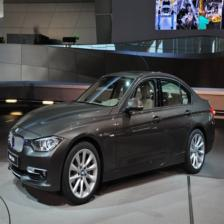

In [41]:
from IPython.display import display
from PIL import Image

test_image = os.listdir(input_dir_cnn)[10]
test_image = os.path.join(input_dir_cnn, test_image)

print(test_image)
display(Image.open(test_image))

In [42]:
img2vec = Img2VecResnet18()
I = Image.open(test_image)
test_vec = img2vec.getVec(I)
I.close()
print(len(test_vec))
print(test_vec)

512
[8.79941642e-01 2.83057284e+00 1.61917174e+00 5.93928099e-01
 1.84517372e+00 1.77712715e+00 3.15100402e-01 3.14232856e-01
 2.43152231e-01 1.21160626e+00 2.30126515e-01 1.06063271e+00
 9.32849199e-02 1.24598372e+00 4.34413739e-02 5.55418372e-01
 1.51587200e+00 1.40234143e-01 2.63578743e-01 2.53767282e-01
 8.38751316e-01 2.17767286e+00 1.10203020e-01 6.33259296e-01
 2.14448631e-01 7.33700633e-01 1.63759816e+00 3.66072011e+00
 1.84950113e-01 3.71897630e-02 9.35642943e-02 5.67644835e-01
 1.96235812e+00 8.21494877e-01 7.34081745e-01 7.27465332e-01
 1.13592160e+00 1.01819158e+00 2.03594461e-01 1.18559170e+00
 1.72633499e-01 2.79253268e+00 5.19833326e-01 9.56324220e-01
 1.30752563e-01 7.15615273e-01 5.26860893e-01 5.63286781e-01
 1.38327146e+00 9.12999988e-01 3.51586252e-01 2.52412230e-01
 9.70155060e-01 2.83728242e-01 3.70639205e-01 6.45042896e-01
 8.78997594e-02 1.62640020e-01 7.01158106e-01 1.65267015e+00
 2.68669873e-01 6.12504900e-01 9.69844341e-01 4.58262384e-01
 2.15554523e+00 2.61

In [43]:
from pyspark.ml.linalg import Vectors

test_vector = Vectors.dense(test_vec)

In [44]:
print("Approximately searching lsh_df for 5 nearest neighbors of input vector:")
result = model.approxNearestNeighbors(lsh_df, test_vector, 5)
result.show()

Approximately searching lsh_df for 5 nearest neighbors of input vector:
+---------+--------------------+--------------------+-------------------+
|      _c0|            features|              hashes|            distCol|
+---------+--------------------+--------------------+-------------------+
|04129.jpg|[0.87994164,2.830...|[[0.0], [-1.0], [...|4.50350095305385E-7|
|04795.jpg|[0.444502,3.27923...|[[0.0], [-1.0], [...| 11.009394855702105|
|02832.jpg|[0.60581183,3.072...|[[-1.0], [-1.0], ...| 11.124157718098502|
|07956.jpg|[0.85402155,1.918...|[[0.0], [-1.0], [...| 11.262015311757784|
|06730.jpg|[0.11903005,3.151...|[[0.0], [-1.0], [...| 11.342232052689395|
+---------+--------------------+--------------------+-------------------+



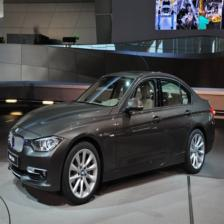

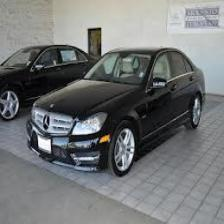

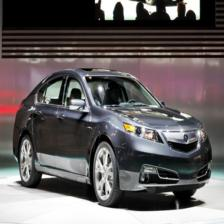

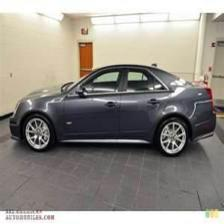

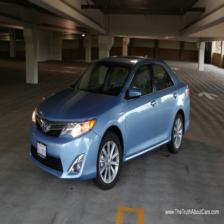

In [45]:
# Display the images of the 5 nearest neighbors
for i in list(result.select('_c0').toPandas()['_c0']):
    display(Image.open(os.path.join(input_dir_cnn, i)))

# `Code Attribution`

Parts of the code used in this project are based on examples from the book:

**"Advanced Analytics with PySpark"** by Akash Tandon, Sandy Ryza, Uri Laserson, Sean Owen, and Josh Wills (O’Reilly).
Copyright 2022 Akash Tandon, 978-1-098-10365-1.